In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

import warnings
from typing import Any, Optional, Union
import torch
from linear_operator.operators import DiagLinearOperator, LinearOperator, ZeroLinearOperator
from torch import Tensor

from gpytorch import settings
from gpytorch.module import Module
from gpytorch.utils.warnings import NumericalWarning, GPInputWarning
from gpytorch.likelihoods.noise_models import HomoskedasticNoise
from gpytorch.likelihoods.gaussian_likelihood import _GaussianLikelihoodBase
from copy import deepcopy
from gpytorch.distributions import MultivariateNormal

In [3]:
class FixedGaussianNoise(Module):
    def __init__(self, noise: Tensor) -> None:
        super().__init__()
        min_noise = settings.min_fixed_noise.value(noise.dtype)
        if noise.lt(min_noise).any():
            warnings.warn(
                "Very small noise values detected. This will likely "
                "lead to numerical instabilities. Rounding small noise "
                f"values up to {min_noise}.",
                NumericalWarning,
            )
            noise = noise.clamp_min(min_noise)
        self.noise = noise

    def forward(
        self, *params: Any, shape: Optional[torch.Size] = None, noise: Optional[Tensor] = None, **kwargs: Any
    ) -> DiagLinearOperator:
        if shape is None:
            p = params[0] if torch.is_tensor(params[0]) else params[0][0]
            shape = p.shape if len(p.shape) == 1 else p.shape[:-1]

        if noise is not None:
            return DiagLinearOperator(noise)
        elif shape[-1] == self.noise.shape[-1]:
            return DiagLinearOperator(self.noise)
        else:
            return ZeroLinearOperator()

    def _apply(self, fn):
        self.noise = fn(self.noise)
        return super(FixedGaussianNoise, self)._apply(fn)

    def __call__(
        self, *params: Any, shape: Optional[torch.Size] = None, **kwargs: Any
    ) -> Union[Tensor, LinearOperator]:
        # For corredct typing
        return super().__call__(*params, shape=shape, **kwargs)

In [4]:
class FixedNoiseGaussianLikelihood(_GaussianLikelihoodBase):
    def __init__(
        self,
        noise: Tensor,
        learn_additional_noise: Optional[bool] = False,
        batch_shape: Optional[torch.Size] = torch.Size(),
        **kwargs: Any,
    ) -> None:
        super().__init__(noise_covar=FixedGaussianNoise(noise=noise))

        self.second_noise_covar: Optional[HomoskedasticNoise] = None
        if learn_additional_noise:
            noise_prior = kwargs.get("noise_prior", None)
            noise_constraint = kwargs.get("noise_constraint", None)
            self.second_noise_covar = HomoskedasticNoise(
                noise_prior=noise_prior, noise_constraint=noise_constraint, batch_shape=batch_shape
            )

    @property
    def noise(self) -> Tensor:
        return self.noise_covar.noise + self.second_noise

    @noise.setter
    def noise(self, value: Tensor) -> None:
        self.noise_covar.initialize(noise=value)

    @property
    def second_noise(self) -> Union[float, Tensor]:
        if self.second_noise_covar is None:
            return 0.0
        else:
            return self.second_noise_covar.noise

    @second_noise.setter
    def second_noise(self, value: Tensor) -> None:
        if self.second_noise_covar is None:
            raise RuntimeError(
                "Attempting to set secondary learned noise for FixedNoiseGaussianLikelihood, "
                "but learn_additional_noise must have been False!"
            )
        self.second_noise_covar.initialize(noise=value)

    def get_fantasy_likelihood(self, **kwargs: Any) -> "FixedNoiseGaussianLikelihood":
        if "noise" not in kwargs:
            raise RuntimeError("FixedNoiseGaussianLikelihood.fantasize requires a `noise` kwarg")
        old_noise_covar = self.noise_covar
        self.noise_covar = None  # pyre-fixme[8]
        fantasy_liklihood = deepcopy(self)
        self.noise_covar = old_noise_covar

        old_noise = old_noise_covar.noise
        new_noise = kwargs.get("noise")
        if old_noise.dim() != new_noise.dim():
            old_noise = old_noise.expand(*new_noise.shape[:-1], old_noise.shape[-1])
        fantasy_liklihood.noise_covar = FixedGaussianNoise(noise=torch.cat([old_noise, new_noise], -1))
        return fantasy_liklihood

    def _shaped_noise_covar(self, base_shape: torch.Size, *params: Any, **kwargs: Any) -> Union[Tensor, LinearOperator]:
        if len(params) > 0:
            # we can infer the shape from the params
            shape = None
        else:
            # here shape[:-1] is the batch shape requested, and shape[-1] is `n`, the number of points
            shape = base_shape

        res = self.noise_covar(*params, shape=shape, **kwargs)

        if self.second_noise_covar is not None:
            res = res + self.second_noise_covar(*params, shape=shape, **kwargs)
        elif isinstance(res, ZeroLinearOperator):
            warnings.warn(
                "You have passed data through a FixedNoiseGaussianLikelihood that did not match the size "
                "of the fixed noise, *and* you did not specify noise. This is treated as a no-op.",
                GPInputWarning,
            )

        return res

    def marginal(self, function_dist: MultivariateNormal, *args: Any, **kwargs: Any) -> MultivariateNormal:
        r"""
        :return: Analytic marginal :math:`p(\mathbf y)`.
        """
        return super().marginal(function_dist, *args, **kwargs)

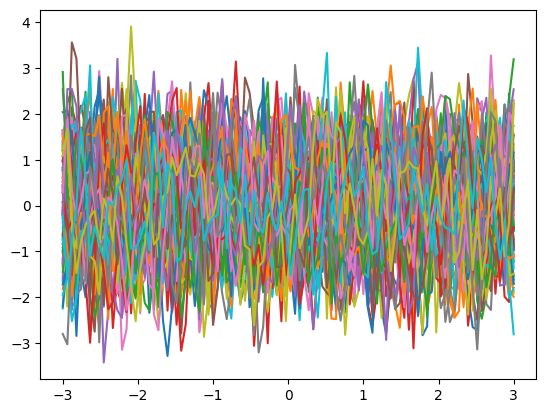

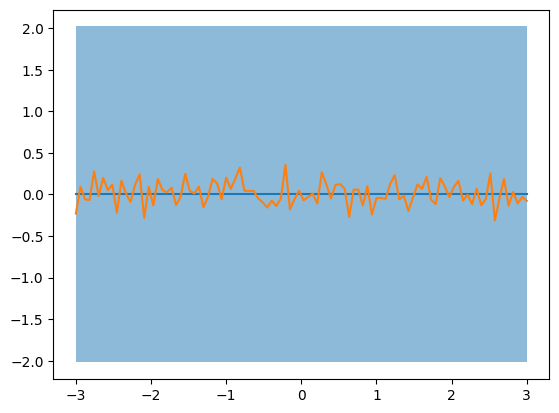

In [28]:
train_x = torch.linspace(-3, 3, 100)

def objective(x):
    mean = gpytorch.means.ConstantMean()
    rbf = gpytorch.kernels.RBFKernel()
    rbf.lengthscale = 0.05
    covar = gpytorch.kernels.ScaleKernel(rbf)
    covar.outputscale = 1.0
    mean.constant = 0.0
    likelihood = FixedNoiseGaussianLikelihood(noise=torch.ones(x.size())*0.02)
    dist = gpytorch.distributions.MultivariateNormal(mean(x), covar(x))

    return likelihood(dist)

dist = objective(train_x)
function_samples = []
for _ in range(100):
    function_samples.append(dist.sample())

train_y = torch.stack(function_samples).mean(dim=1)
noises = torch.stack(function_samples).std(dim=1)

with torch.no_grad():
    fig, ax = plt.subplots()
    for i in range(100):
        ax.plot(train_x, function_samples[i])
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot(train_x, dist.mean)
    lower, upper = dist.confidence_region()
    ax.fill_between(train_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.plot(train_x, train_y)
    
    plt.show()

In [5]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = FixedNoiseGaussianLikelihood(noise=noises)
model = ExactGPModel(train_x, train_y, likelihood)

In [6]:
training_iter = 20

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f ' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item()
    ))
    optimizer.step()

Iter 1/20 - Loss: 1.497   lengthscale: 0.693 
Iter 2/20 - Loss: 1.495   lengthscale: 0.744 
Iter 3/20 - Loss: 1.494   lengthscale: 0.797 
Iter 4/20 - Loss: 1.492   lengthscale: 0.852 
Iter 5/20 - Loss: 1.491   lengthscale: 0.910 
Iter 6/20 - Loss: 1.489   lengthscale: 0.971 
Iter 7/20 - Loss: 1.488   lengthscale: 1.034 
Iter 8/20 - Loss: 1.486   lengthscale: 1.100 
Iter 9/20 - Loss: 1.485   lengthscale: 1.169 
Iter 10/20 - Loss: 1.483   lengthscale: 1.239 
Iter 11/20 - Loss: 1.482   lengthscale: 1.310 
Iter 12/20 - Loss: 1.481   lengthscale: 1.383 
Iter 13/20 - Loss: 1.480   lengthscale: 1.456 
Iter 14/20 - Loss: 1.478   lengthscale: 1.530 
Iter 15/20 - Loss: 1.477   lengthscale: 1.604 
Iter 16/20 - Loss: 1.476   lengthscale: 1.678 
Iter 17/20 - Loss: 1.475   lengthscale: 1.751 
Iter 18/20 - Loss: 1.474   lengthscale: 1.823 
Iter 19/20 - Loss: 1.473   lengthscale: 1.894 
Iter 20/20 - Loss: 1.473   lengthscale: 1.963 


In [7]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_1649/2517954370.py:71: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


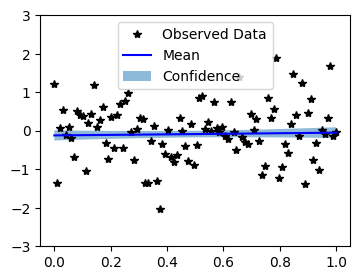

In [8]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])